In [1]:
from promisces import *
import numpy as np

# Getting started

`promisces` exposes classes and objects with which you can configure simulations.

## known entities

`Substances`, `Matrices` and `Treatments` are objects whose attributes refer to (from `promisces`) known `Substance`, `Matrix` and `Treatment` (respectively).
For example, 
- `Matrices.rww` returns a `Matrix` instance corresponding to "raw wastewater"
- `Substances.pfoa` returns a `Substance` instance corresponding to "Perfluorooctanoic acid"

## configurable entities

There are several classes exposed by `promisces` with which you can configure the remaining parameters of a simulation. The most important are:

1. `StartingConcentration(array: np.ndarray, substance: Substance, matrix: Matrix)` where the values in `array` are in ng / L.
2. `TreatmentTrain(treatments: list[Treatment, ...])` for defining the treatment train of the simulation.

## example simulation

### inputs

The next cell configures and runs an example simulation. The function `simulate_removal()` takes the following input arguments:

```
treatment_train: TreatmentTrain,
substance: Substance,
input_matrix: Matrix,
n_runs: int = 10000,
    # the number of removal factors to simulate at each steps
rmv_factor_resolution: int = 1000,
    # removal factors will be drawn between 1/rmv_factor_resolution and 1 - 1/rmv_factor_resolution
```

the last three arguments to `simulate_removal()`

```
case_study: Optional[CaseStudy] = None,
reference: Reference | None = None,
scenario: str = ""
```

are optional. They allow you to provide custom data to the simulation.

> Note that, by default, `simulate_removal()` uses only literature data for building a probability distribution of the removal factor for a given treatment.

### outputs

The object returned by `simulate_removal()` is an instance of `SimulationResult` and allows you to access various informations about the simulation, as well as exporting a summary to excel.

- `result.output_c_df`: a `pandas.DataFrame` of the estimated output concentrations of `substance` after each treatment.
- `result.rmv_factor_df`: a `pandas.DataFrame` of the drawn removal factors at each treatment step.
- `result.treatment_df`: a `pandas.DataFrame` summarizing the treatments.
- `result.export_excel(filename)` a method to write statistical descriptions of `output_c_df` and `rmv_factor_df` as well as `treatments_df` into an excel file with name `filename`.

Those are demonstrated in the cells following the next cell.

### ER profiles

To plot the ER profiles of the result, simply do

```
er_profiles(result)
```

if you provide a path through the `save_as` argument, the plot will be saved at this path. Eg

```
er_profiles(result, save_as="example-profile.png")
```




In [2]:
substance = Substances.pfoa
input_matrix = Matrices.rww

start_c = StartingConcentration(
    np.array([100]),
    substance, matrix
)

treatment_train = TreatmentTrain([
    Treatments.wwtt,
    Treatments.wwco,
    Treatments.dwae,
    Treatments.dwrf,
    Treatments.dwac,
])

result = simulate_removal(
    treatment_train,
    substance,
    input_matrix,
    n_runs = 10_000,
    rmv_factor_resolution = 1000
)

In [3]:
result.output_c_df

,input,wwtt,wwco,dwae,dwrf,dwac
0,317.282396,376.650566,0.316965,323.971842,0.283083,15.211450
1,31.666559,472.285407,0.031635,410.005603,0.028664,36.454008
2,532.325884,91.792882,0.531794,79.963350,0.482917,7.349272
3,382.631684,491.907613,0.382249,433.920068,0.347117,66.756867
4,273.585651,462.442689,0.273312,412.086380,0.248192,64.632864
...,...,...,...,...,...,...
9995,462.905594,0.273586,412.498878,0.248441,64.697562,0.000248
9996,492.400013,0.382632,434.354422,0.347464,66.823690,0.000347
9997,91.884767,0.532326,80.043393,0.483400,7.356628,0.000483
9998,472.758166,0.031667,410.416019,0.028693,36.490499,0.000029


In [4]:
result.rmv_factor_df

,wwtt,wwco,dwae,dwrf,dwac
0,0.1,0.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.1
4,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...
9995,99.9,10.8,9.1,84.3,99.9
9996,99.9,11.7,9.1,84.6,99.9
9997,99.9,12.8,9.1,90.8,99.9
9998,99.9,13.1,9.3,91.1,99.9


In [5]:
result.treatment_df

,treatment_id,average_out,input_matrix,output_matrix,dominant_data,substance,n_runs,removal_factor_resolution
0,wwtt,False,Raw wastewater,Treated wastewater,Literature,Perfluorooctanoic acid,10000,1000
1,wwco,False,Treated wastewater,Treated wastewater,Literature,Perfluorooctanoic acid,10000,1000
2,dwae,False,Treated wastewater,Drinking water,Combination,Perfluorooctanoic acid,10000,1000
3,dwrf,False,Drinking water,Drinking water,Combination,Perfluorooctanoic acid,10000,1000
4,dwac,False,Drinking water,Drinking water,Prior,Perfluorooctanoic acid,10000,1000


In [6]:
result.export_excel("example-simulation.xlsx")

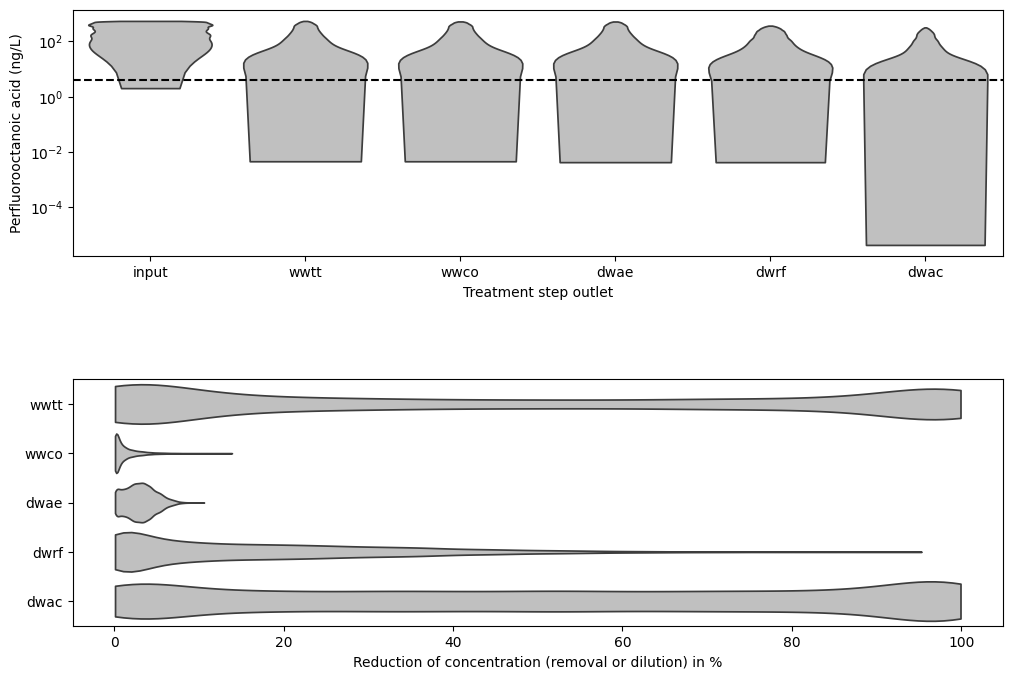

In [7]:
er_profiles(result)
None

## `CaseStudy`

with the `CaseStudy` class, you can 
- define specific `RemovalPercent` for given `treatment` and `substance`.
- define `Mixture` parameters for mixing and separation treatments.
- define `StartingConcentration` for a `substance` and a `matrix`
- provide `Reference` values used for plotting ER profiles

The case studies defined in `promisces/models/case_study.py` will show you examples.

If you provide a `CaseStudy` instance to `simulate_removal` through the `case_study` argument, the simulation will extract relevant data from the case study and use it:
- if the `CaseStudy` contains a matching `StartingConcentration`, it will be used instead of literature data.
- if the `CaseStudy` contains matching `RemovalPercent`s, those will be used in combination with the ones available in the literature.

> Note that providing a `CaseStudy` to `simulate_removal()` is the only way to specify `Mixture` parameters for mixing and separation treatments.

> Note also that you can assign `Mixture` definition to various `scenario` within the case study.


the following cell shows you how to define and use a `CaseStudy` to run simulations with different scenari and do a `spider_plot` of all the runs.

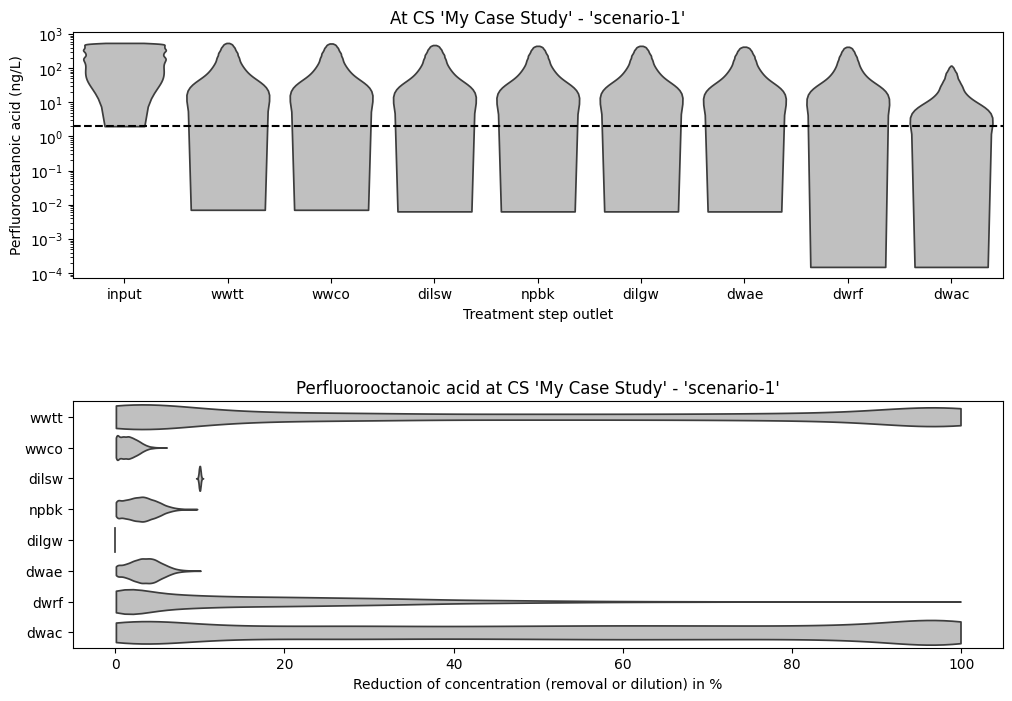

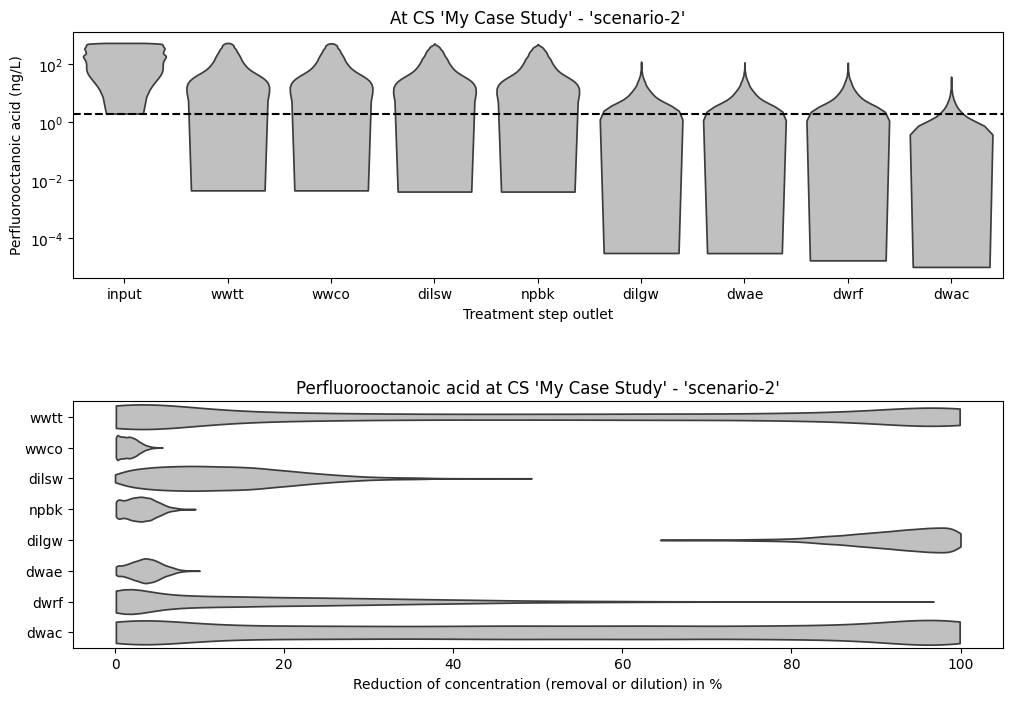

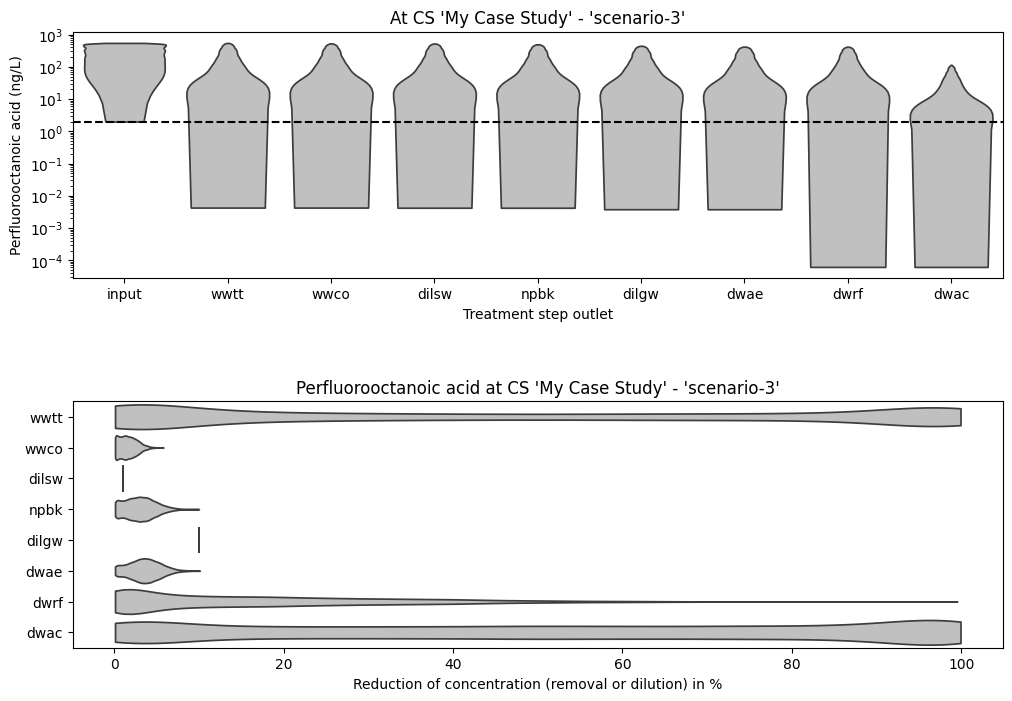

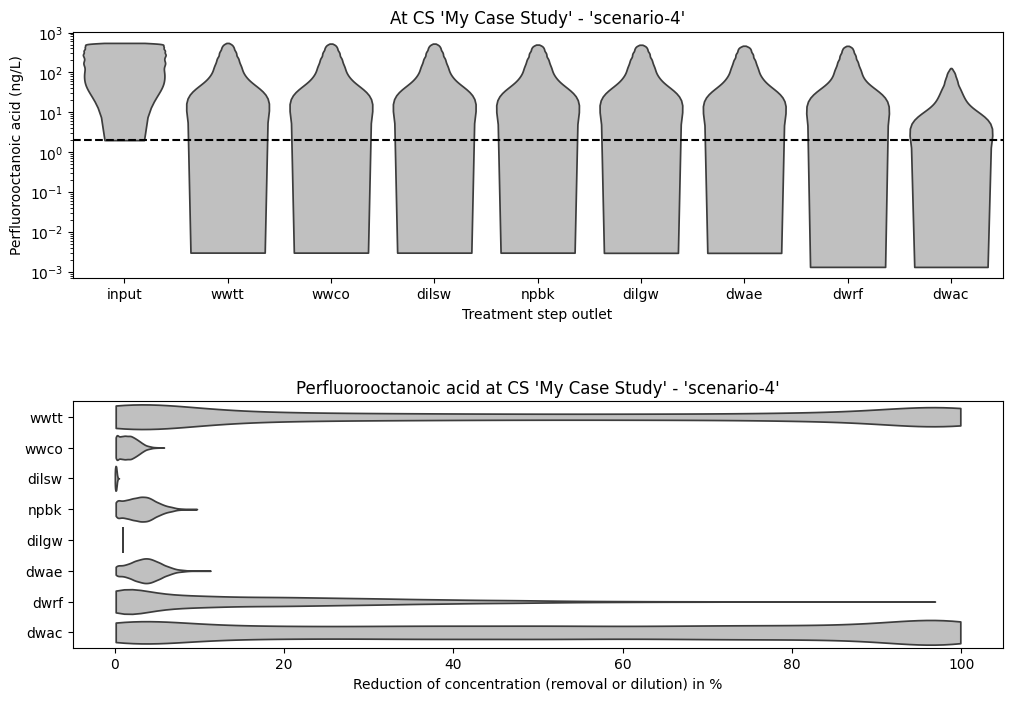

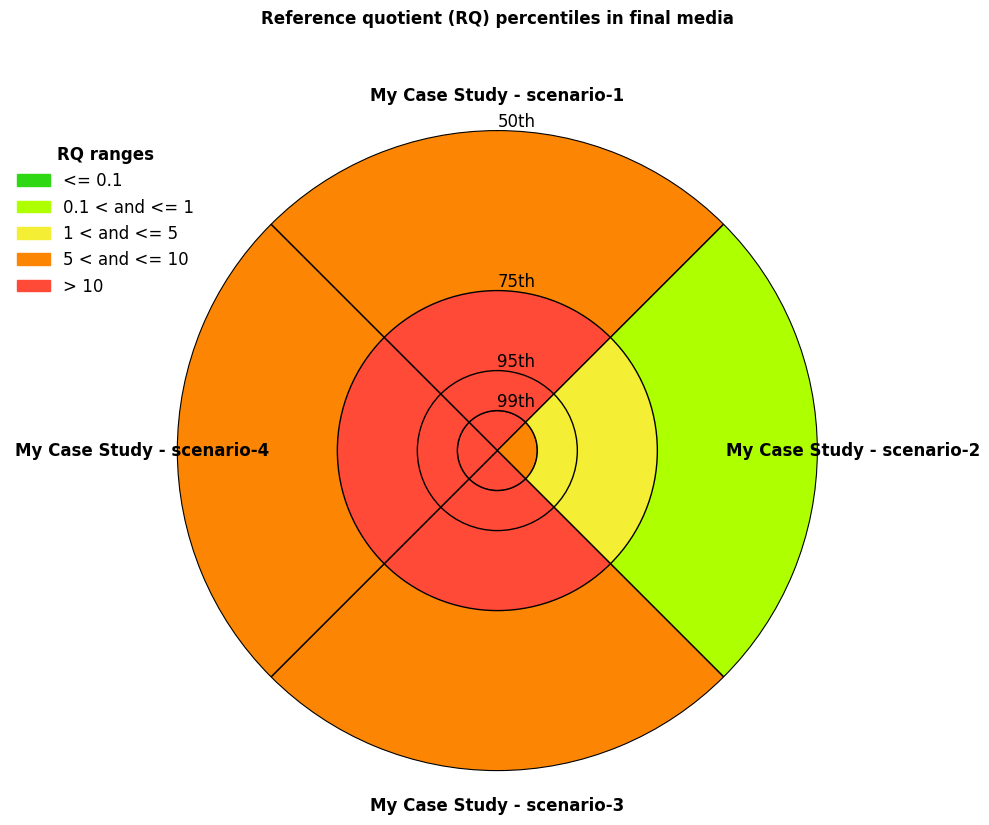

In [11]:
my_case_study = CaseStudy(
    name="My Case Study",
    mixtures=[
        Mixture(0, 0, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-1"),
        Mixture(1, .1, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-2"),
        Mixture(.1, 0, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-3"),
        Mixture(.01, 0, 0, 0, Treatments.dilgw, Substances.pfoa, scenario="scenario-4"),
        Mixture(0.1, 0.001, 0, 0, Treatments.dilsw, Substances.pfoa, scenario="scenario-1"),
        Mixture(.1, .1, 0, 0, Treatments.dilsw, Substances.pfoa, scenario="scenario-2"),
        Mixture(.01, 0, 0, 0, Treatments.dilsw, Substances.pfoa, scenario="scenario-3"),
        Mixture(.001, .001, 0, 0, Treatments.dilsw, Substances.pfoa, scenario="scenario-4"),
    ],
    removal_percents=[
        RemovalPercent(np.array([1, 2, 3, 4]), Treatments.wwco, Substances.pfoa),
        RemovalPercent(np.array([10, 20, 30, 40]), Treatments.dwae, Substances.pfoa),
    ],
    references=[
        Reference("ref-1234", # the reference id
                  Substances.pfoa, Matrices.drw,
                  ref_value_ng_l=2.0,
                  year=2021,
                  comments="just an example")
    ],
    starting_concentration=[
        StartingConcentration(
            np.array([100., 300., 500.]), Substances.pfoa, Matrices.grw
        )]
)

substance = Substances.pfoa
input_matrix = Matrices.rww

start_c = StartingConcentration(
    np.array([100]),
    substance, matrix
)

treatment_train = TreatmentTrain([
    Treatments.wwtt,
    Treatments.wwco,
    Treatments.dilsw,
    Treatments.npbk,
    Treatments.dilgw,
    Treatments.dwae,
    Treatments.dwrf,
    Treatments.dwac,
])

all_results = []
for scenario in ["scenario-1", "scenario-2", "scenario-3", "scenario-4"]:
    result = simulate_removal(
        treatment_train,
        substance,
        input_matrix,
        n_runs = 10_000,
        rmv_factor_resolution = 1000,
        case_study=my_case_study,
        scenario=scenario
    )
    fig = er_profiles(result)
    result.export_excel(scenario + ".xlsx")
    all_results += [result]

spider_plot(all_results)
None